# 5: Time Series

The hand-in exercise for this topic is Task 3,4 and 6 from the notebook “TSA_Task”. This
means that you have to do the cleaning of dataset, then create features (at least 5 new
features should be created, and you should be able to justify why you created each of
the features). And then, you should train an XGBoost model on the dataset. Note that
you also need to do relevant train, test, validation split and be able to explain why you
chose a certain split. Lastly, you should calculate evaluation metrics: rmse and mae to
show performance of your model. The hyperparameter tuning part is not required.

---

### Imports:

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Get the dataset w kaggleHub

In [61]:
path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\danie\.cache\kagglehub\datasets\lakshmi25npathi\bike-sharing-dataset\versions\1


In [62]:
dataset_path = "C:/Users/danie/.cache/kagglehub/datasets/lakshmi25npathi/bike-sharing-dataset/versions/1"

files = os.listdir(dataset_path)
print(files)

['day.csv', 'hour.csv', 'Readme.txt']


In [63]:
file_path = "C:/Users/danie/.cache/kagglehub/datasets/lakshmi25npathi/bike-sharing-dataset/versions/1/hour.csv"

df = pd.read_csv(file_path)

---

### Task 3 from TSA_task:

* Clean and pre-process the dataset as required and prepare the data for modelling.

First look EDA:

Using .head(), .info() and .describe() function to get a initial understanding of the data we are handling.
Also checking if we need to adress any missing values or other inconsistencies.

In [64]:
# Look at first 10 records in the data frane
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


No missing values in this data, so no need to do cleaning/transformation for now

In [66]:
# Use this to ensure there are no absurd outliers before beginning analysis
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


There seem to be no extreme outliers in this data, so we proceed to analysis.

---

### Task 4 from TSA_task:

* Create the lag and rolling windows features for the "cnt" column such as: 1 day lag, 1 week lag, 1 month, etc. and last 3 day rolling

A 'lag' is a when a data record is shifted to a previous time step, it makes it possible to describe the history of records in the data, enabling time based analysis. Lets add the lag features of 1 day, 1 wekk and 1 month to the dataframe.

In [67]:
# Making lag features for the 'cnt' feature, trying to make the bike rental history easier to read
df['cnt_lag_1d'] = df['cnt'].shift(24)  # 1 day)
df['cnt_lag_1w'] = df['cnt'].shift(24 * 7)  # 1 week
df['cnt_lag_1m'] = df['cnt'].shift(24 * 30)  # 1 month

In [68]:
# Create rolling window features for 'cnt'
df['roll_mean_3h']  = df['cnt'].rolling(window=3).mean()    # Last 3 hours rolling mean
df['roll_mean_3d']  = df['cnt'].rolling(window=72).mean()     # Last 3 days rolling mean (72 hours)

A rolling window feature calculates a mean sum over a specified window of time

In [69]:
# lets make a window of 3 days
df['cnt_roll_3d'] = df['cnt'].rolling(window=24 * 3, min_periods=1).mean()

Lets take a look at our new features to see if they seem useful

In [70]:
# Using data sample instead of data head here, as first few values will always be NaN since there are no previous data to calculate result from
df.sample(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,cnt_lag_1d,cnt_lag_1w,cnt_lag_1m,roll_mean_3h,roll_mean_3d,cnt_roll_3d
1889,1890,2011-03-24,2,0,3,12,0,4,1,2,...,0.3284,12,82,94,87.0,185.0,93.0,76.666667,98.430556,98.430556
11651,11652,2012-05-05,2,1,5,16,0,6,0,2,...,0.3881,230,310,540,440.0,376.0,269.0,503.000000,280.680556,280.680556
12805,12806,2012-06-22,3,1,6,18,0,5,1,2,...,0.1940,62,443,505,640.0,693.0,327.0,510.333333,256.263889,256.263889
8143,8144,2011-12-10,4,0,12,23,0,6,0,1,...,0.1642,5,61,66,94.0,85.0,89.0,81.333333,140.722222,140.722222
14781,14782,2012-09-13,3,1,9,2,0,4,1,1,...,0.0000,0,9,9,11.0,8.0,11.0,31.333333,321.944444,321.944444
16730,16731,2012-12-04,4,1,12,21,0,2,1,2,...,0.2537,28,252,280,221.0,232.0,227.0,348.666667,242.847222,242.847222
6718,6719,2011-10-12,4,0,10,12,0,3,1,3,...,0.3284,9,53,62,181.0,214.0,184.0,98.333333,202.847222,202.847222
7921,7922,2011-12-01,4,0,12,17,0,4,1,1,...,0.1343,9,409,418,380.0,114.0,298.0,257.666667,143.069444,143.069444
4599,4600,2011-07-15,3,0,7,13,0,5,1,1,...,0.1940,85,162,247,177.0,229.0,189.0,231.666667,197.486111,197.486111
13098,13099,2012-07-04,3,1,7,23,1,3,0,2,...,0.0896,31,152,183,171.0,159.0,86.0,423.000000,281.805556,281.805556


Makes it very conveniet to analyse variables like sales or rentals overtime

---

### Task 6 from TSA_task:

* Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

To accomplish this task and train a XGBoost model, we must first make sure the data includes the following:

* Convert dteday to datetime format
* Create features 'hour', 'day', 'weekday', 'month' and 'year'
* Make a train/test split on the data

In [71]:
# Convert 'date' to datetime format
df['dteday'] = pd.to_datetime(df['dteday'])
# Create time-based features
df['hour'] = df['hr']
df['day'] = df['dteday'].dt.day
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year
df['weekday'] = df['dteday'].dt.weekday  # 0 = Monday, 6 = Sunday
# Take a look at the dataframe after adding in the above
df.sample(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,cnt_lag_1d,cnt_lag_1w,cnt_lag_1m,roll_mean_3h,roll_mean_3d,cnt_roll_3d,hour,day,month,year
10107,10108,2012-03-02,1,1,3,5,0,4,1,1,...,18.0,2.0,4.0,9.666667,156.402778,156.402778,5,2,3,2012
597,598,2011-01-28,1,0,1,2,0,4,1,2,...,10.0,59.0,NaN,4.666667,60.347222,60.347222,2,28,1,2011
13078,13079,2012-07-04,3,1,7,3,1,2,0,1,...,2.0,8.0,5.0,82.666667,256.388889,256.388889,3,4,7,2012
16907,16908,2012-12-12,4,1,12,6,0,2,1,2,...,118.0,124.0,24.0,56.333333,191.250000,191.250000,6,12,12,2012
14953,14954,2012-09-20,3,1,9,6,0,3,1,1,...,172.0,195.0,169.0,77.333333,257.666667,257.666667,6,20,9,2012
12225,12226,2012-05-29,2,1,5,14,0,1,1,1,...,465.0,222.0,653.0,238.000000,256.361111,256.361111,14,29,5,2012
15568,15569,2012-10-15,4,1,10,21,0,0,1,1,...,196.0,151.0,296.0,233.666667,273.277778,273.277778,21,15,10,2012
7345,7346,2011-11-07,4,0,11,16,0,0,1,1,...,347.0,272.0,496.0,203.333333,158.625000,158.625000,16,7,11,2011
1784,1785,2011-03-20,1,0,3,1,0,6,0,1,...,51.0,86.0,6.0,38.000000,126.958333,126.958333,1,20,3,2011
2513,2514,2011-04-19,2,0,4,15,0,1,1,2,...,176.0,78.0,136.0,121.000000,123.694444,123.694444,15,19,4,2011


Few preprocessing steps before training the XGBoost model

In [72]:
df = df.dropna()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16659 entries, 720 to 17378
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   instant       16659 non-null  int64         
 1   dteday        16659 non-null  datetime64[ns]
 2   season        16659 non-null  int64         
 3   yr            16659 non-null  int64         
 4   mnth          16659 non-null  int64         
 5   hr            16659 non-null  int64         
 6   holiday       16659 non-null  int64         
 7   weekday       16659 non-null  int32         
 8   workingday    16659 non-null  int64         
 9   weathersit    16659 non-null  int64         
 10  temp          16659 non-null  float64       
 11  atemp         16659 non-null  float64       
 12  hum           16659 non-null  float64       
 13  windspeed     16659 non-null  float64       
 14  casual        16659 non-null  int64         
 15  registered    16659 non-null  int64    

Implement the model:

In [73]:
# For an hourly dataset, 7 days = 168 hours.
train = df.iloc[:-168].copy()   # Training set: all data except the last week
test = df.iloc[-168:].copy()      # Test set: the last week of data

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (16491, 27)
Test shape: (168, 27)


Testing the lag length, it should be 7 days, so the span from 24th -> 31st seems correct

In [74]:
print("Test period from", test['dteday'].min(), "to", test['dteday'].max())

Test period from 2012-12-24 00:00:00 to 2012-12-31 00:00:00


In [75]:
# Define the features for XGBoost; adjust based on your earlier feature engineering.
FEATURES_XGB = [
    'hr', 'weekday', 'mnth', 'yr',  # basic time features
    'cnt_lag_1d', 'cnt_lag_1w', 'cnt_lag_1m',     # lag features: 1 day, 1 week, 1 month lags
    'roll_mean_3h', 'roll_mean_3d'     # rolling means: last 3 hours, last 3 days
]
TARGET = 'cnt'

# Create training and test feature matrices and target vectors
X_train_xgb = train[FEATURES_XGB].copy()
y_train_xgb = train[TARGET].copy()
X_test_xgb = test[FEATURES_XGB].copy()
y_test_xgb = test[TARGET].copy()

# If any non-numeric column (e.g., 'dteday') exists in X, drop it.
for col in ['dteday']:
    if col in X_train_xgb.columns:
        X_train_xgb = X_train_xgb.drop(columns=[col])
    if col in X_test_xgb.columns:
        X_test_xgb = X_test_xgb.drop(columns=[col])

print("Features used:", FEATURES_XGB)
print(X_train_xgb.head())

Features used: ['hr', 'weekday', 'mnth', 'yr', 'cnt_lag_1d', 'cnt_lag_1w', 'cnt_lag_1m', 'roll_mean_3h', 'roll_mean_3d']
     hr  weekday  mnth  yr  cnt_lag_1d  cnt_lag_1w  cnt_lag_1m  roll_mean_3h  \
720   9        2     2   0       116.0         9.0        16.0    109.000000   
721  10        2     2   0        47.0        36.0        40.0    113.000000   
722  11        2     2   0        51.0       108.0        32.0     78.666667   
723  12        2     2   0        55.0       238.0        13.0     59.000000   
724  13        2     2   0        52.0       144.0         1.0     63.666667   

     roll_mean_3d  
720     58.555556  
721     58.875000  
722     58.708333  
723     58.777778  
724     58.472222  


### Take aways

* The model gives information about bike rental trends over specified time rolls

In [76]:
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

params = {
    'objective': 'reg:squarederror',  # Regression objective
    'eval_metric': 'rmse',             # Use RMSE for evaluation
    'max_depth': 3,                    # Maximum depth of trees
    'learning_rate': 0.01,             # Learning rate
    'colsample_bytree': 0.8,           # Subsample of features
    'subsample': 0.8,                  # Subsample ratio of observations
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 4000
early_stopping_rounds = 50

# Train the XGBoost model with early stopping
model = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=100)

print("Best iteration:", model.best_iteration)

[0]	train-rmse:181.84086	eval-rmse:141.02598
[100]	train-rmse:93.16480	eval-rmse:69.89618
[200]	train-rmse:64.01471	eval-rmse:46.14807
[300]	train-rmse:54.57088	eval-rmse:37.66048


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[400]	train-rmse:50.29993	eval-rmse:34.13478
[500]	train-rmse:47.60191	eval-rmse:31.83483
[600]	train-rmse:45.54984	eval-rmse:30.29491
[700]	train-rmse:43.83596	eval-rmse:28.95693
[800]	train-rmse:42.37358	eval-rmse:28.22465
[900]	train-rmse:41.23747	eval-rmse:27.57251
[1000]	train-rmse:40.19393	eval-rmse:27.12325
[1100]	train-rmse:39.15105	eval-rmse:26.58069
[1200]	train-rmse:38.29214	eval-rmse:26.35911
[1300]	train-rmse:37.46454	eval-rmse:26.15777
[1400]	train-rmse:36.64457	eval-rmse:25.96036
[1498]	train-rmse:35.97494	eval-rmse:25.96761
Best iteration: 1448


Trying out the best amount of iterations

Lets try amd visualize the Actual vs Predicted bike rentals:

XGBoost - Test RMSE: 25.96761006448105
XGBoost - Test MAE: 18.541391372680664


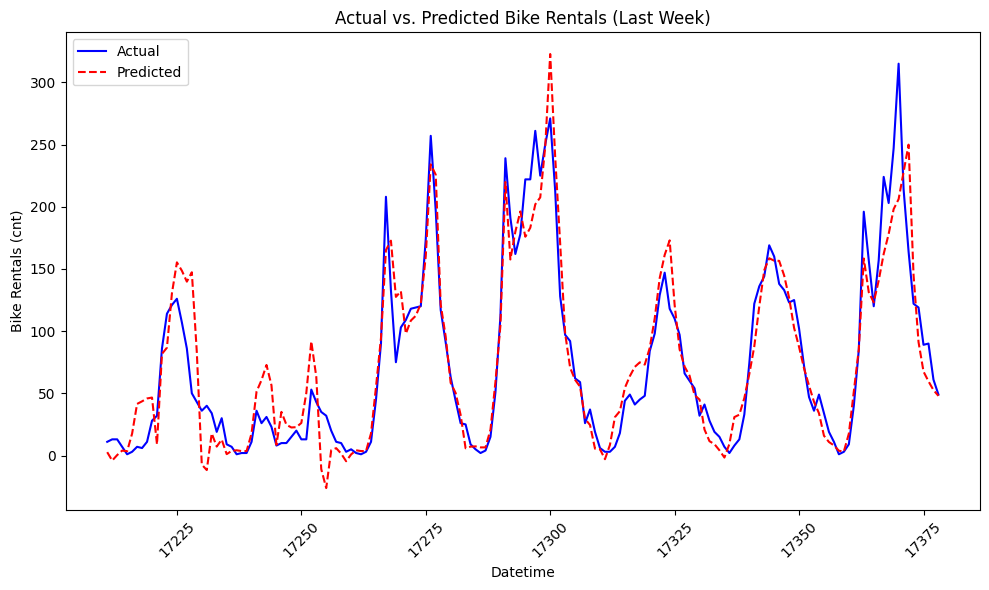

In [77]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
y_pred_xgb = model.predict(dtest)

# Calculate RMSE and MAE
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)

print("XGBoost - Test RMSE:", rmse_xgb)
print("XGBoost - Test MAE:", mae_xgb)

# Plot actual vs. predicted counts for the last week
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test_xgb, label='Actual', color='blue')
plt.plot(test.index, y_pred_xgb, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs. Predicted Bike Rentals (Last Week)')
plt.xlabel('Datetime')
plt.ylabel('Bike Rentals (cnt)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()